# Network Analysis on Auckland road data
### Import packages

In [14]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools

### Importing territorial boundry of Auckland region

In [ ]:
auckland_path = "data/geographic/territorial/auckland_polygon_diy.gpkg"
auckland = gpd.read_file(auckland_path)
auckland = auckland.to_crs(crs=4326)
polygonauck = auckland.iloc[0]['geometry']

In [ ]:
waiheke_path = "data/geographic/territorial/waiheke_polygon.gpkg"
waiheke = gpd.read_file(waiheke_path)
waiheke = waiheke.to_crs(crs=4326)
polygonwaiheke = waiheke.iloc[0]['geometry']

### Generating the road network

In [10]:
Gwalk_auck = ox.graph.graph_from_polygon(polygonauck, network_type="walk", simplify = False)

In [12]:
Gwalk_auck.graph['streets_per_node']

{'created_date': '2023-03-13 17:31:19',
 'created_with': 'OSMnx 1.2.2',
 'crs': 'epsg:4326'}

In [ ]:
# Add speed and travel time
Gwalk_auck = ox.add_edge_speeds(Gwalk_auck)
Gwalk_auck = ox.add_edge_travel_times(Gwalk_auck)
print("added all")
Auckland_waiheke_walk = nx.compose(Gwalk_auck,Gwalk_waiheke)
ox.io.save_graphml(Auckland_waiheke_walk, "data/network_analysis/auckland_waiheke_network_walk.graphml")

In [ ]:
Gwalk_waiheke = ox.graph.graph_from_polygon(polygonwaiheke, network_type="walk", simplify = False)
print("created")
Gwalk_waiheke = ox.add_edge_speeds(Gwalk_waiheke)
Gwalk_waiheke = ox.add_edge_travel_times(Gwalk_waiheke)
print("added all")

In [3]:
G = ox.io.load_graphml("data/network_analysis/auckland_waiheke_network_walk.graphml")

In [5]:
ox.stats.streets_per_node_counts(G)

{0: 0,
 1: 32367,
 2: 478407,
 3: 83990,
 4: 14240,
 5: 271,
 6: 34,
 7: 2,
 8: 3,
 9: 1}

In [7]:
streets_per_node_counts = ox.stats.streets_per_node_counts(G)

In [6]:
statsG = ox.stats.basic_stats(G)


In [17]:
streets_per_node_counts

{0: 0,
 1: 32367,
 2: 478407,
 3: 83990,
 4: 14240,
 5: 271,
 6: 34,
 7: 2,
 8: 3,
 9: 1}

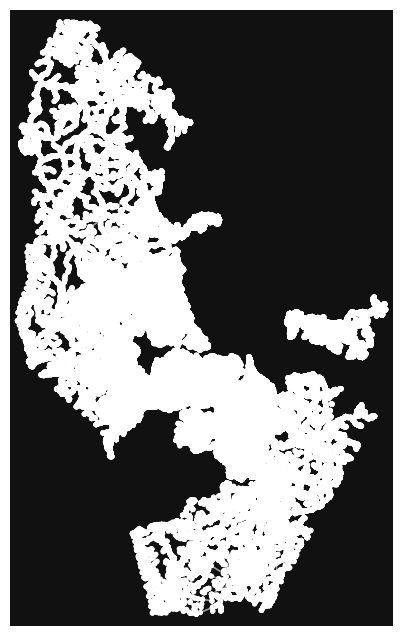

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [4]:
ox.plot.plot_graph(G)

In [ ]:
G_consolifull = ox.simplification.simplify_graph(G, strict=True)
ox.plot.plot_graph(G_consolifull)


Save for future use

In [5]:
ox.io.save_graph_geopackage(G_consolifull, "data/network_analysis/full_auckland_waiheke_walk_simplified.gpkg")

In [15]:
ox.io.save_graphml(G, filepath="data/network_analysis/auckland_network_bike_unconsolidated.graphml", gephi=False, encoding='utf-8')

### Consolidate the newtork to solve the spatial/topological issue

In [11]:
G_consoli = ox.simplification.consolidate_intersections(G, rebuild_graph=False)

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:405: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid


In [3]:
# get the nodes and the edges into geopandas
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Get 3-or-more-way intersections

In [6]:
streets_per_node = G.graph['streets_per_node']

KeyError: 'streets_per_node'

In [ ]:
node_ids = set(G.nodes())

intersections = [node for node, count in streets_per_node.items() if count>3]
dead_ends = [node for node, count in streets_per_node.items() if count==1]

# Bus Freqnecy from GTSF

In [6]:
df = pd.read_csv("data/transport/public_transport/GTFS/gtfs_auckland/stop_times.txt",sep=",", encoding="gbk")
df.drop(columns=df.columns[-4:], axis=1,  inplace=True)

In [ ]:
# sum bus departures from bus stops per day
df2 = df.groupby(by='stop_id').count().sort_values(by='arrival_time',ascending=False)

df2['busDepsPerHour'] = df2['departure_time']/24 # get average buses per hour
df2 = df2.loc[df2['busDepsPerHour'] >= 6] #select bus stops with more than 6 buses per hour, approximation of buses every 10 minutes

df2.to_csv("bus_frequency.csv") #save, joining with spatial bus stops was done in QGIS